# Lendingkart Customer Loan Approval and Segmentation

Tujuan dari project ini adalah untuk mengembangkan model prediksi persetujuan pinjaman yang efektif untuk memprediksi apakah pengajuan pinjaman oleh pelanggan akan disetujui atau tidak, dengan mempertimbangkan variabel yang relevan. Selain itu, kami juga akan melakukan segmentasi pelanggan untuk mengidentifikasi kelompok-kelompok tertentu yang membantu dalam merancang strategi pemasaran yang lebih tepat dan pendekatan yang sesuai agar dapat meningkatkan pendapatan secara signifikan.

# Introduction

Mia Yulia Nurrizky (HCK006)

seorang mantan Data Officer dengan pengalaman berharga dalam pengelolaan data, dan saat ini tengah mengejar karir sebagai Data Scientist. Dengan dasar kuat dalam mengenali potensi data, saya telah mengembangkan keterampilan dalam analisis data menggunakan Python, SQL, dan berbagai tools penting lainnya. Saya memiliki tekad untuk memberikan dampak positif melalui solusi data-driven, dan semangat untuk terus belajar dan berkembang dalam dunia analisis data yang dinamis. Dengan ketekunan dan komitmen, saya siap membawa kontribusi yang bermakna bagi tim Anda.


# External Link

**Deployment Link** : https://huggingface.co/spaces/miayulia/Lendingkart-FinalProject

# Working Area

## **Import Library**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#Preprocessing and Modelling for Classification
import phik
from phik.report import plot_correlation_matrix
from statsmodels.stats.outliers_influence import variance_inflation_factor
import sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold
from feature_engine.outliers import Winsorizer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from imblearn.pipeline import Pipeline as ImbPipeline

#Preprocessing and Modelling for Clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,silhouette_samples
from sklearn.metrics import silhouette_score,silhouette_samples
import matplotlib.cm as cm


#Model Evaluation
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_score

#Save Modelling
import joblib
import pickle

import warnings
warnings.filterwarnings(action='ignore')

%matplotlib inline



## **Data Loading**

In [2]:
#load data
df = pd.read_csv('loan_approval_dataset.csv')

In [3]:
df.head()

,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   loan_id                    4269 non-null   int64 
 1    no_of_dependents          4269 non-null   int64 
 2    education                 4269 non-null   object
 3    self_employed             4269 non-null   object
 4    income_annum              4269 non-null   int64 
 5    loan_amount               4269 non-null   int64 
 6    loan_term                 4269 non-null   int64 
 7    cibil_score               4269 non-null   int64 
 8    residential_assets_value  4269 non-null   int64 
 9    commercial_assets_value   4269 non-null   int64 
 10   luxury_assets_value       4269 non-null   int64 
 11   bank_asset_value          4269 non-null   int64 
 12   loan_status               4269 non-null   object
dtypes: int64(10), object(3)
memory usage: 433.7+ KB


Pada dataset ini, terdapat 4269 baris dan 13 kolom yang terdiri dari 10 kolom tipe integer dan 3 kolom tipe object. Berdasarkan overview, tidak ada nilai null dalam dataset ini.

## **Data Cleaning**

#### *Missing Value*

In [5]:
df.isna().sum()

loan_id                      0
 no_of_dependents            0
 education                   0
 self_employed               0
 income_annum                0
 loan_amount                 0
 loan_term                   0
 cibil_score                 0
 residential_assets_value    0
 commercial_assets_value     0
 luxury_assets_value         0
 bank_asset_value            0
 loan_status                 0
dtype: int64

Tidak ada missing value.

#### *Duplicate*

In [6]:
df.duplicated().sum()

0

Tidak ada data duplikat.

#### *Rename Columns*

In [7]:
df.columns

Index(['loan_id', ' no_of_dependents', ' education', ' self_employed',
       ' income_annum', ' loan_amount', ' loan_term', ' cibil_score',
       ' residential_assets_value', ' commercial_assets_value',
       ' luxury_assets_value', ' bank_asset_value', ' loan_status'],
      dtype='object')

Terdapat karakter ' ' (spasi) pada setiap nama kolom. Sehingga, untuk memudahkan pengolahan data, maka karakter spasi akan dihilangkan.

In [8]:
df.columns = df.columns.str.replace(' ', '')

#### *Drop Columns*

Karena `loan_id` merupakan nomer/index pada dataset, dan tidak memiliki pengaruh terhadap pengolahan data pada proses analisis maupun modelling, makan kolom `loan_id` akan di drop.

In [9]:
df.drop('loan_id', inplace=True, axis=1)

## **EDA**

In [10]:
#melihat overview dari kolom numerik
df.describe().T

,count,mean,std,min,25%,50%,75%,max
no_of_dependents,4269.0,2.498712e+00,1.695910e+00,0.0,1.0,3.0,4.0,5.0
income_annum,4269.0,5.059124e+06,2.806840e+06,200000.0,2700000.0,5100000.0,7500000.0,9900000.0
loan_amount,4269.0,1.513345e+07,9.043363e+06,300000.0,7700000.0,14500000.0,21500000.0,39500000.0
loan_term,4269.0,1.090045e+01,5.709187e+00,2.0,6.0,10.0,16.0,20.0
cibil_score,4269.0,5.999361e+02,1.724304e+02,300.0,453.0,600.0,748.0,900.0
residential_assets_value,4269.0,7.472617e+06,6.503637e+06,-100000.0,2200000.0,5600000.0,11300000.0,29100000.0
commercial_assets_value,4269.0,4.973155e+06,4.388966e+06,0.0,1300000.0,3700000.0,7600000.0,19400000.0
luxury_assets_value,4269.0,1.512631e+07,9.103754e+06,300000.0,7500000.0,14600000.0,21700000.0,39200000.0
bank_asset_value,4269.0,4.976692e+06,3.250185e+06,0.0,2300000.0,4600000.0,7100000.0,14700000.0


Berdasarkan perhitungan central tendencies, dapat diketahui bahwa :
- jumlah *dependents* atau tanggungan setiap pelanggan berkisar antara 0-3 orang.
- rata-rata pendapatan tahunan calon debitur Lendingkart adalah  ₹5.059.124.
- pendapatan tahunan tertinggi calon debitur Lendingkart yaitu ₹9.900.000 per tahun.
- jumlah pinjaman calon debitur Lendingkart berkisar dari ₹300.000-₹39.500.000 dengan tenor 2-20 bulan.
- pelanggan calon debitur Lendingkart rata-rata memiliki credit score (CIBIL) yaitu 600 yang berarti ada pada tingkat tengah, yang menunjukkan bahwa pelanggan tersebut memiliki riwayat kredit yang lumayan baik namun mungkin pernah terlewat pembayaran dari tanggal jatuh tempo.
- terdapat nilai minus pada nilai aset residential dari calon debitur Lendingkart yang mengindikasikan bahwa ada pelanggan yang memiliki hutang aset residential
- aset komersial yang dimiliki calon debitur Lendingkart berkisar antara ₹1.300.000-₹7.600.000, sedangkan nilai asset banknya berkisar dari ₹2.300.000-₹4.600.000 yang menunjukkan bahwa debitur berinvestasi ke 2 aset ini cukup seimbang jumlahnya.
- aset luxury termahal yang dimiliki calon debitur Lendingkart yaitu ₹39.200.000.

In [11]:
#melihat overview dari kolom kategorik
df[list(df.select_dtypes(include='object'))].describe()

,education,self_employed,loan_status
count,4269,4269,4269
unique,2,2,2
top,Graduate,Yes,Approved
freq,2144,2150,2656


Dapat dilihat bahwa :
- dari 4269 calon debitur, 2656 orang `Approved` ajuan pinjamannya.
- mayoritas calon debitur adalah lulusan dari sekolah/universitas dan memiliki usaha/self employed

(array([0, 1]), [Text(0, 0, ' Approved'), Text(1, 0, ' Rejected')])

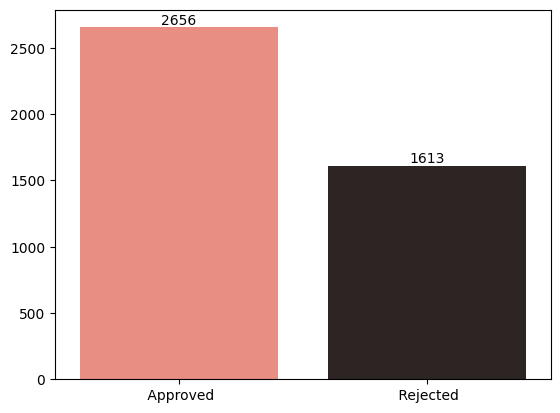

In [12]:
#melihat distribusi loan_status
status = sns.barplot(x=df['loan_status'].value_counts().index,
            y=df['loan_status'].value_counts().values, palette='dark:salmon_r')

plt.bar_label(status.containers[0])
plt.xticks()

Distribusi `loan_status` pada data ini tidak seimbang, dengan proporsi 60:40. 60% calon debitur `Approved` dan 40% lainnya `Rejected`. Pada data ini tidak termasuk data *extreme imbalance* sehingga tidak perlu dilakukan manipulasi data untuk memudahkan proses modelling. Namun dapat diketahui juga bahwa calon debitur masih banyak yang mengajukan pinjaman tanpa evaluasi apakah dirinya bisa diberikan pinjaman atau tidak, dilihat masih banyaknya calon debitur yang `Rejected` sekaligus mengindikasi bahwa Lendingkart sangat teliti dan berhati-hati dalam memberikan pinjaman.

Text(0.5, 1.0, 'Income vs Loan Amount')

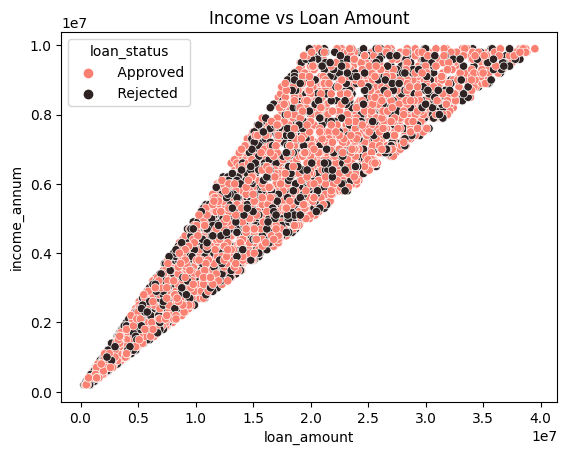

In [13]:
#melihat korelasi pendapatan tahunan dan jumlah pinjaman
sns.scatterplot(data=df, x='loan_amount', y='income_annum', hue='loan_status', palette='dark:salmon_r')
plt.title('Income vs Loan Amount')

Berdasarkan grafik, diketahui bahwa ada korelasi antara jumlah pinjaman dan pendapatan. Calon debitur yang memiliki pendapatan tinggi cenderung mengajukan pendapatan yang nominalnya tinggi juga. Sejalan dengan teori apabila pendapatan meningkat maka kebutuhan meningkat, yang berarti calon debitur mengajukan pinjaman tinggi karena kebutuhanya tinggi. Selain itu, karena kemampuan bayarnya juga lebiih tinggi dibandingkan dengan pendapatan tahunan yang rendah. Pinjaman paling tinggi yaitu pada calon debitur yang memiliki pendapatan ₹10.000.000 pertahun namun mengajukan pinjaman sebanyak 4x pendapatan tahunan.  

Text(0.5, 1.0, 'Bank Asset Value vs Loan Amount')

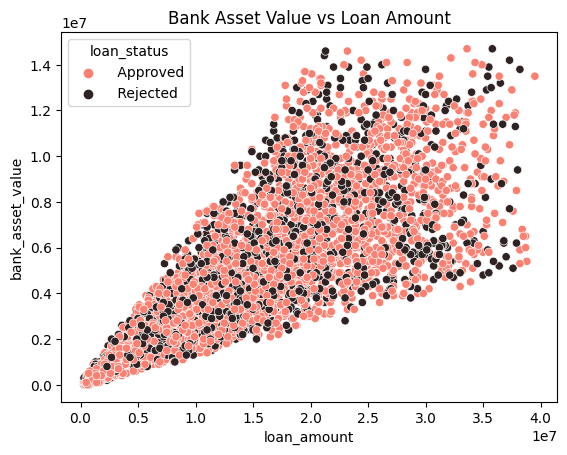

In [14]:
#melihat korelasi nilai aset bank dan jumlah pinjaman
sns.scatterplot(data=df, x='loan_amount', y='bank_asset_value', hue='loan_status', palette='dark:salmon_r')
plt.title('Bank Asset Value vs Loan Amount')

Serupa dengan pendapatan tahunan, nilai aset bank juga memiliki korelasi positif dengan jumlah pinjaman yang diajukan. Perilaku calon debitur serupa yaitu apabila memiliki nilai aset yang tinggi atau pendapatan tinggi maka ia berani untuk mengajukan pinjaman dengan nilai yang tinggi juga karena merasa mampu untuk membayar pinjamannya. Hal ini berlaku juga kepada aset komersial/aset residential/aset luxury yang dimiliki pleh calon debitur. Aset-aset tersebut juga bisa dijadikan jaminan apabila suatu saat debitur tidak mampu membayar tagihannya.

<Axes: xlabel='education', ylabel='count'>

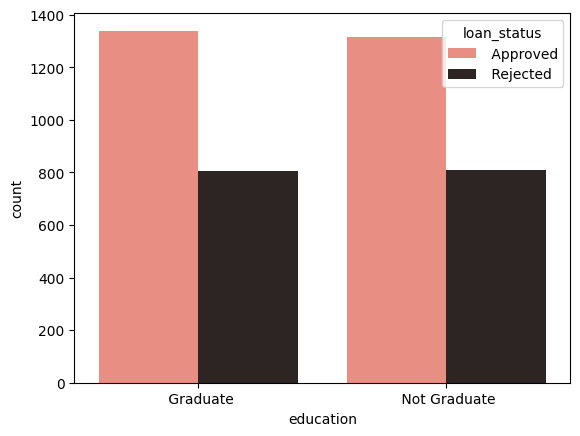

In [15]:
#melihat sebaran tingkat pendidikan antara calon debitur yang diterima dan ditolak
sns.countplot(data=df, x="education", hue="loan_status", palette='dark:salmon_r')

Tidak ada perbedaan signifikan antara status pendidikan yang sudah `Graduate` dan `Not Graduate` pada calon debitur yang `Approved` maupun `Rejected`. Hal ini berarti bahwa tidak ada kemungkinan korelasinya antara pendidikan dengan status pinjaman.

<Axes: xlabel='self_employed', ylabel='count'>

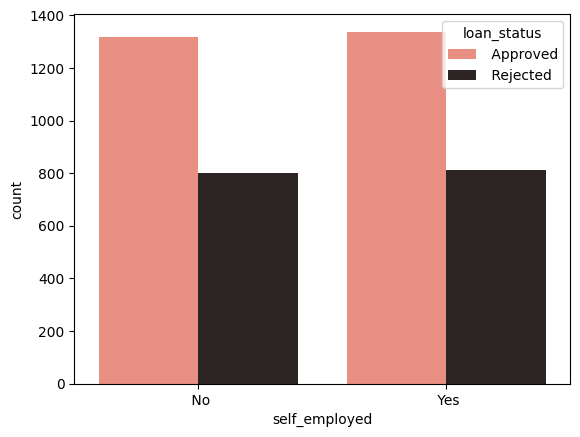

In [16]:
#melihat sebaran status pekerjaan antara calon debitur yang diterima dan ditolak
sns.countplot(data=df, x="self_employed", hue="loan_status", palette='dark:salmon_r')

Tidak ada perbedaan signifikan antara status pendidikan yang sudah `Graduate` dan `Not Graduate` pada calon debitur yang `Approved` maupun `Rejected`. Hal ini berarti bahwa tidak ada kemungkinan korelasinya antara pendidikan dengan status pinjaman.

<Axes: xlabel='loan_term', ylabel='count'>

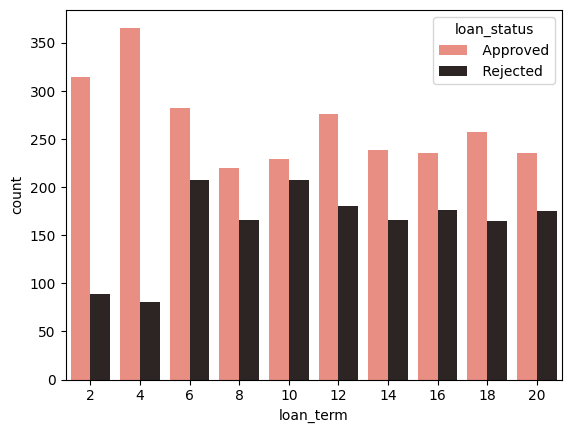

In [17]:
#melihat tenor pinjaman yang diajukan antara calon debitur yang diterima dan ditolak
sns.countplot(data=df, x="loan_term", hue="loan_status", palette='dark:salmon_r')

Grafik scatterplot di atas menunjukkan bahwa debitur yang mengajukan pinjaman dengan tenor 2-4 bulan cukup sedikit yang ditolak, karena mayoritas tenor pinjaman yang diterima adalah dengan jangka waktu 2-4 bulan. Hal ini kemungkinan disebabkan karena rendahnya risiko untuk gagal bayar. Selanjutnya akan dilihat berapa jumlah pinjaman yang diajukan dengan tenor 2-4 bulan.

In [18]:
#query loan term=2&4
lt = df.loc[(df['loan_term'] == 2) | (df['loan_term'] == 4)]

#query tabel loan amount & loan term
print('minimum loan amount:', lt[['loan_amount','loan_term']].min())
print('maximum loan amount:', lt[['loan_amount','loan_term']].max())
print('maximum loan amount:', lt[['loan_amount','loan_term']].mean())

minimum loan amount: loan_amount    400000
loan_term           2
dtype: int64
maximum loan amount: loan_amount    38700000
loan_term             4
dtype: int64
maximum loan amount: loan_amount    1.489918e+07
loan_term      3.050529e+00
dtype: float64


Diketahui bahwa pada kelompok tenor 2 dan 4 bulan, calon debitur mengajukan pinjaman paling sedikit ₹400.000 dan paling banyak ₹3.8700.000.

Selain itu ditemukan bahwa calon debitur ditolak, mayoritas tenor pinjamanya 6 dan 10 bulan. Sebaliknya pada calon debitur yang diterima, paling sedikit tenor pinjamannya 6 dan 10 bulan. Selanjutnya akan dilihat jumlah pinjaman yang diajukan pada kelompok 6 dan 10 bulan.

In [19]:
#query loan term=2&4
lt1 = df.loc[(df['loan_term'] == 6) | (df['loan_term'] == 10)]

#query tabel loan amount & loan term
print('minimum loan amount:', lt1[['loan_amount','loan_term']].min())
print('maximum loan amount:', lt1[['loan_amount','loan_term']].max())
print('maximum loan amount:', lt1[['loan_amount','loan_term']].mean())

minimum loan amount: loan_amount    300000
loan_term           6
dtype: int64
maximum loan amount: loan_amount    38700000
loan_term            10
dtype: int64
maximum loan amount: loan_amount    1.544795e+07
loan_term      7.883369e+00
dtype: float64


Tidak ada perbedaan yang dignifikan dari jumlah pinjaman yang diajukan baik dari nilai minimum, maksimum, serta nilai rata-rata. Hal ini jumlah pinjaman tidak secara signifikan mempengaruhi *Loan Approval*. 

Secara teori, yang paling mempengaruhi hal tersebut adalah credit score/CIBIL score. Oleh karena itu akan dilihat distribusinya dengan grafik.

<Axes: xlabel='cibil_score', ylabel='Count'>

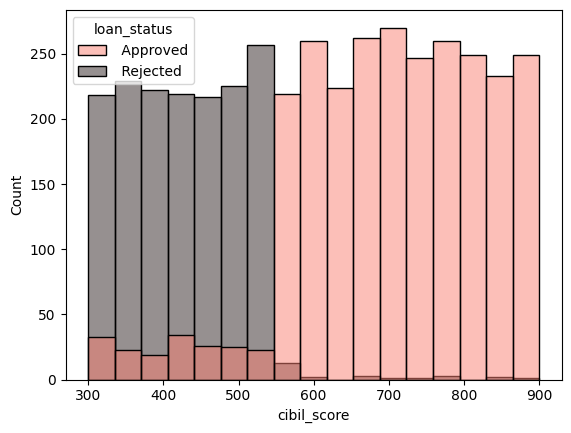

In [20]:
#melihat tenor pinjaman yang diajukan antara calon debitur yang diterima dan ditolak
sns.histplot(df, x="cibil_score", hue="loan_status", palette='dark:salmon_r')

Dapat dibuktikan bahwa calon debitur yang memiliki CIBIL score antara 300-550 ditolak ajuan pinjamannya. Meskipun ada beberapa calon debitur yang diterima, tapi ada faktor lain sebagai pertimbangan sehingga ajuan pinjamannya diterima. Namun hal ini hanya terjadi di beberapa kasus saja atau sangat sedikit. CIBIL score cukup menunjukkan bahwa ada keterkaitan antara `cibil_score` dengan `loan_status`

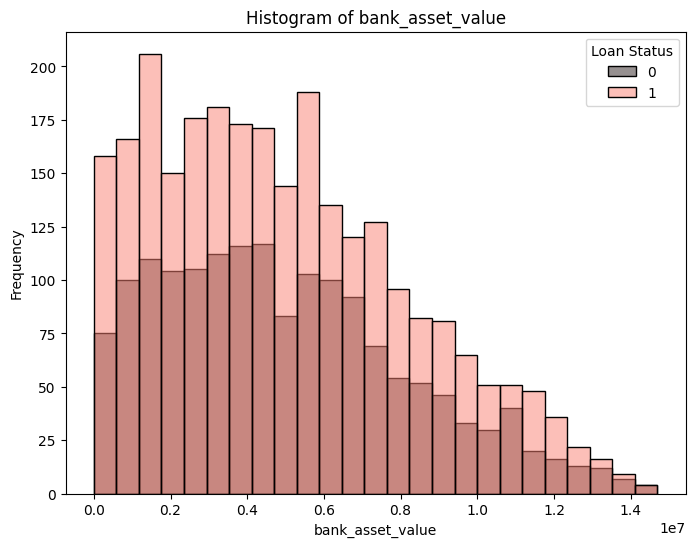

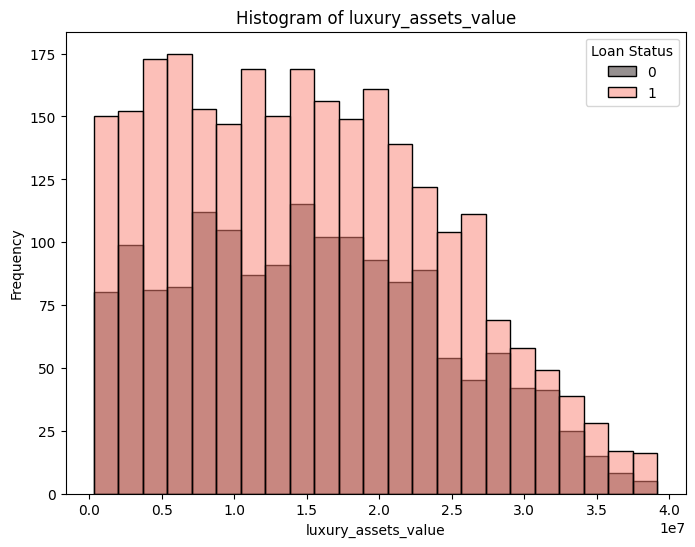

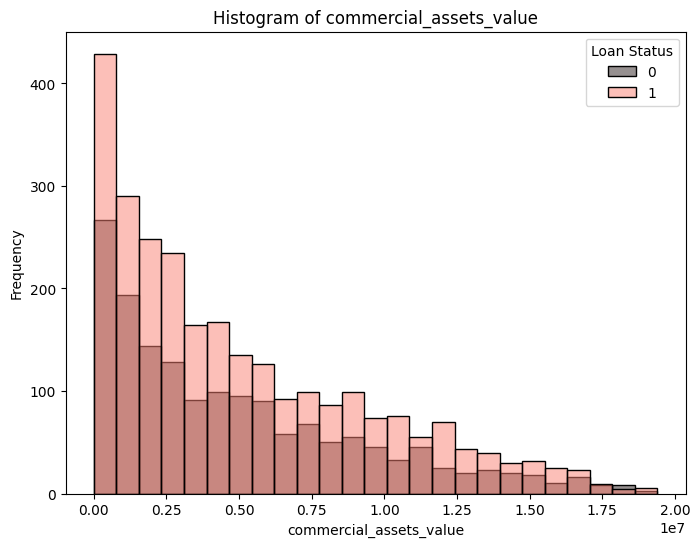

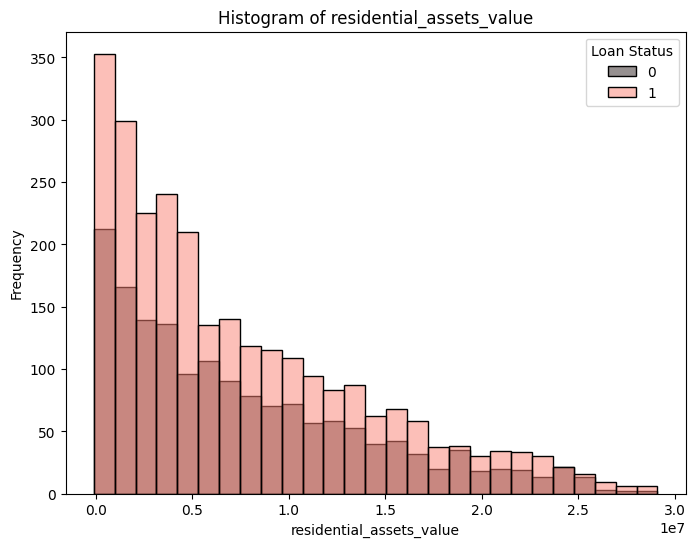

In [21]:
#melihat distribusi berdasarkan jenis-jenis aset
def plot_histogram(df, column_name):
    plt.figure(figsize=(8, 6))
    sns.histplot(data=df, x=column_name, hue="loan_status", palette='dark:salmon_r')
    plt.title(f'Histogram of {column_name}')
    plt.xlabel(column_name)
    plt.ylabel('Frequency')
    plt.legend(title='Loan Status', labels=['0', '1'])
    plt.show()

plot_histogram(df, "bank_asset_value")
plot_histogram(df, "luxury_assets_value")
plot_histogram(df, "commercial_assets_value")
plot_histogram(df, "residential_assets_value")

Dari ketiga jenis aset yaitu `residential assets value`, `commercial assets value`, `luxury assets value`, dan `bank assets value`, dapat disimpulkan bahwa tidak ada keterkaitannya dengan `loan_status`. Pada sebaran data dalam grafik, nilai aset dari masing-masing jenis, nilai aset yang paling mahalpun tidak mempengaruhi ditolaknya sebuah ajuan pinjaman. Namun meskipun tidak ada keterkaitannya, aset-aset ini bisa dijadikan sebagai jaminan para debitur untuk mengajukan pinjamannya untuk mengurangi risiko gagal bayar oleh para debitur. Sebagai tambahan, mempertimbangkan berbagai jenis aset sebagai jaminan dapat membantu dalam diversifikasi portofolio pinjaman calon debitur. Ini bisa mengurangi risiko yang terkait dengan ketergantungan pada jenis aset tertentu.

## **Feature Engineering**

#### *Feature Selection*

Sebelum masuk ke dalam preprocesing dan modelling, akan dilakukan feature selection untuk memilih feature-feature yang berpengaruh kepada suatu keputusan apakah sebuah ajuan pinjaman akan diterima atau ditolak.

In [22]:
#mengelompokkan kolom interval
interval_cols = ['no_of_dependents', 'income_annum', 'loan_amount', 'loan_term', 'cibil_score', 
                'residential_assets_value', 'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value']

#kalkulasi korelasi dengan matrix Phik
phik_overview = df.phik_matrix(interval_cols=interval_cols)

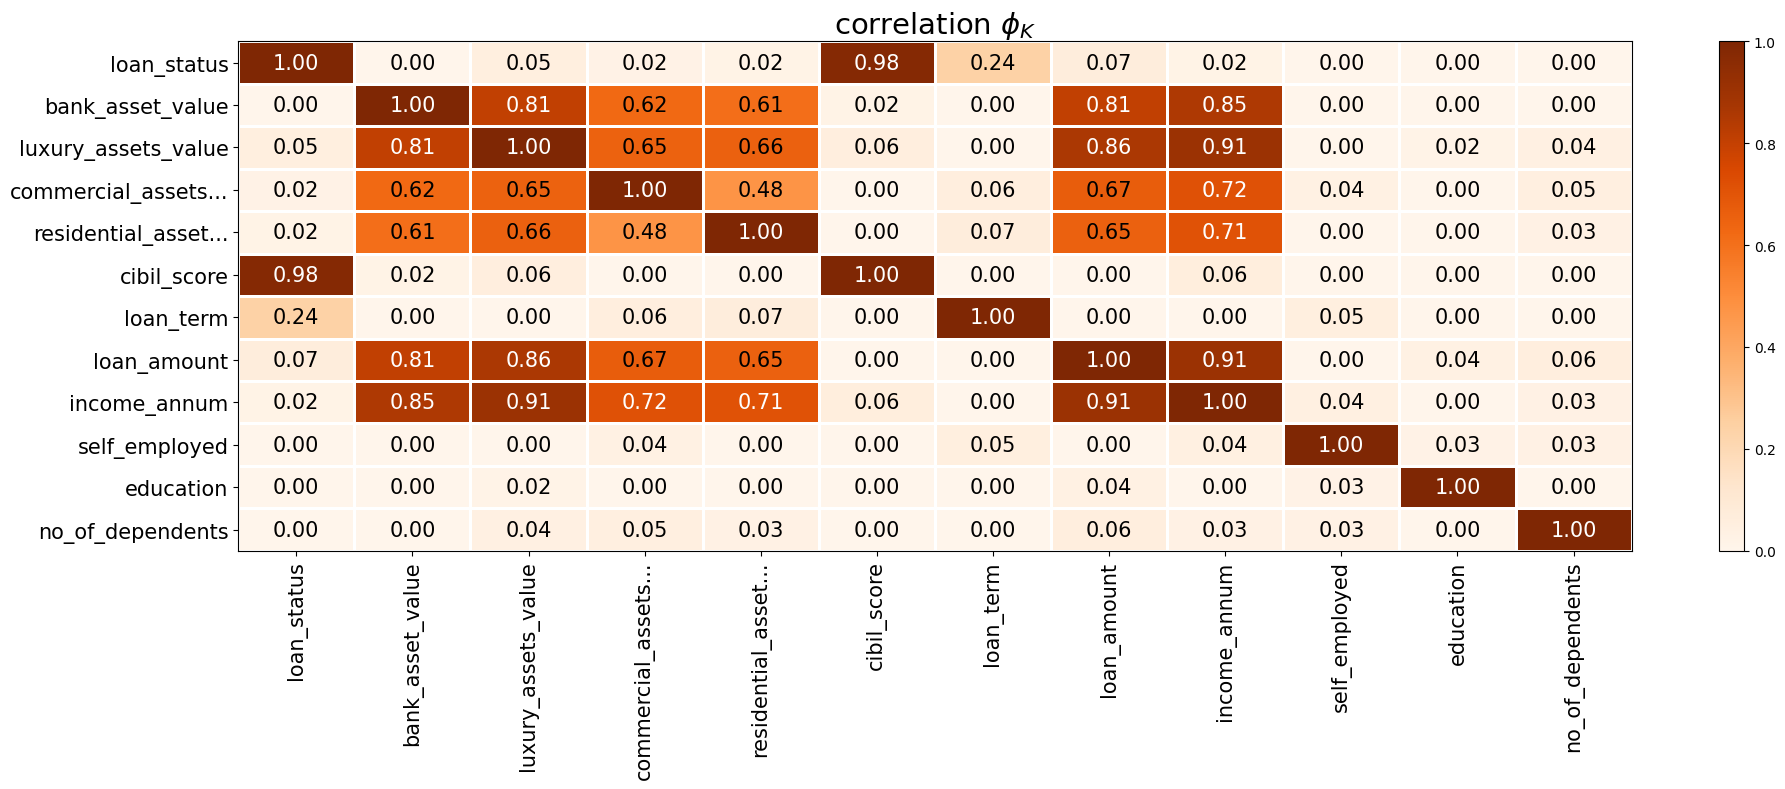

In [23]:
#melihat grafik korelasi
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Oranges", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(20, 8))
plt.tight_layout()

Berdasarkan kalkulasi perhitungan korelasi dengan `Phi-k`, feature yang memiliki pengaruh paling tinggi dengan `loan_status` adalah `cibil_score` dengan nilai korelasi 0.98 dan `loan_term` dengan nilai korelasi 0.24. Feature lain seperti `luxury_assets_value`, `commercial_assets_value`, `residential_assets_value`, `loan_amount`, dan `income_amount` memiliki korelasi yang sangat kecil yaitu dibawah 0.1. Sedangkan pada feature `no_of_dependents`, `education`, `self_employed`, dan `bank_asset_value` tidak memiliki korelasi sama sekali. 

Hal ini sejalan dengan Exploratory Data Analysis yang telah dilakukan, dimana calon debitur yang memiliki `cibil_score` > 550 dan `loan_term` < 6 bulan cenderung untuk diterima ajuan pinjamannya. sedangkan faktor lainnya, berdasarkan grafik tidak memiliki keterkaitan yang signifikan.

Sehingga `loan_term` dan `cibil_score` akan dimasukkan ke dalam modelling feature

In [24]:
#membuat df dengan feature yang sudah diseleksi
dfnew = df[['loan_status', 'cibil_score', 'loan_term']]

#### *VIF*

Untuk mencegah multikolinearitas pada feature, akan dilakukan pengecekan nilai VIF.

In [25]:
#VIF dengan data numerik
def vifcalculation(df):

    # menghitung VIF
    vif = pd.DataFrame()
    vif["variables"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]

    return(vif)

#VIF Calculation
vifcalculation(dfnew[['cibil_score', 'loan_term']])

,variables,VIF
0,cibil_score,3.657748
1,loan_term,3.657748


Nilai VIF pada masing-masing feature bernilai < 5, sehingga tidak multikolinear dan bisa digunakan dalam modelling.

### **Split**

In [26]:
#Split data feature dan target
X = dfnew.drop(['loan_status'], axis=1)
le = LabelEncoder() #encode target
y = le.fit_transform(dfnew['loan_status'])

In [27]:
#Split data train dan test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)

#melihatukuran data set test dan train
print('Train Size:', X_train.shape)
print('Test Size:', X_test .shape)

Train Size: (2988, 2)
Test Size: (1281, 2)


Data dibagi menjadi Train dan Test, dengan proporsi 70:30. pada data Train terdapat sebanyak 2988 baris, dan data Test sebanyak 1281 baris.

#### *Outlier*

Dilakukan pengecekan outlier untuk menentukan apakah perlu handling outlier dan pengecekan nilai Skew untuk menentukan metode Handling Outlier dan Scaling

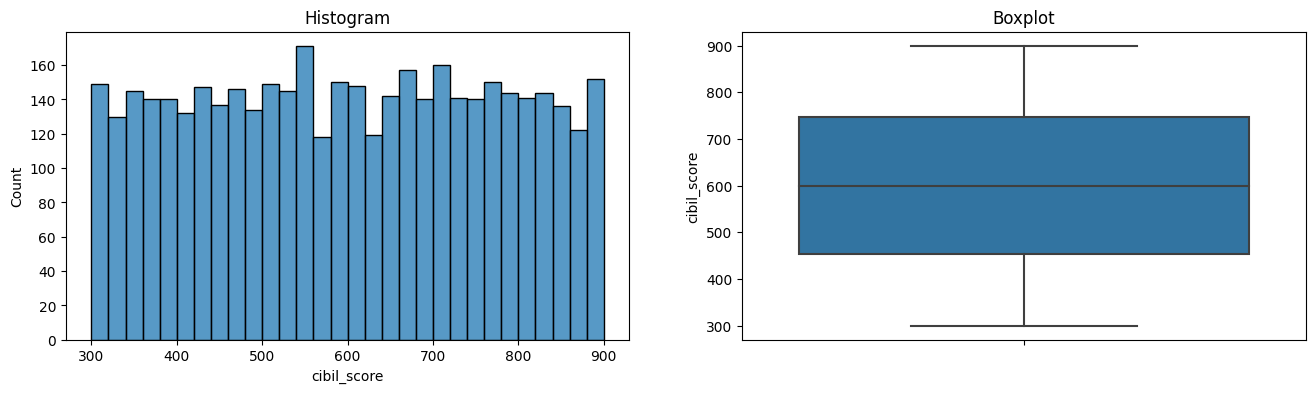


Skewness Value :  -0.009039277330065707


In [28]:
#fungsi plot sebaran data
def diagnostic_plots(dfnewest, variable):
    # Define figure size
    plt.figure(figsize=(16, 4))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(df[variable], bins=30)
    plt.title('Histogram')
    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

#distribution of Weight
diagnostic_plots(X_train, 'cibil_score')
print('\nSkewness Value : ', df['cibil_score'].skew())

Tidak terdapat outlier pada `cibil_score` dan nilai skew yang didapatkan adalah 0.09. Hal ini berarti bahwa tidak perlu dilakukan handling outlier dan metode scaling yang digunakan adalah `Standard Scaler` karena distribusinya normal (nilai skew <1).

#### Feature Scaling

In [29]:
#scaling cibil_score with pipeline
Xc_pipeline = Pipeline([
    ('scaler', StandardScaler())
    ])

#fit transform pipeline numerikal
Xctrain = Xc_pipeline.fit_transform(X_train[['cibil_score']])
Xctest = Xc_pipeline.transform(X_test[['cibil_score']])
Xctrain

array([[-0.74223272],
       [-1.65257569],
       [-0.94965264],
       ...,
       [ 0.3697685 ],
       [-0.21792126],
       [ 0.41010015]])

In [30]:
#combine scaled cibil score and loan term
full = ColumnTransformer([
    ('xcs', Xc_pipeline, ['cibil_score']),
    ('xlt', 'passthrough', ['loan_term'])
])

X_train_final = full.fit_transform(X_train)
X_test_final = full.transform(X_test)
X_train_final

array([[-0.74223272,  8.        ],
       [-1.65257569,  4.        ],
       [-0.94965264, 20.        ],
       ...,
       [ 0.3697685 ,  4.        ],
       [-0.21792126, 18.        ],
       [ 0.41010015,  6.        ]])

## Modelling Classifiction

Selanjutnya dilakukan pengecekan label pada `loan_status`

In [31]:
#show loan status value
print(dfnew['loan_status'].head(3))
print(y)

0     Approved
1     Rejected
2     Rejected
Name: loan_status, dtype: object
[0 1 1 ... 1 0 0]


`loan_status` yang berstatus `Approved` di beri label `0`, sedangkan yang `Rejected` diberi label `1`

In [32]:
#model definition
dt = DecisionTreeClassifier(random_state=0)
rf = RandomForestClassifier(random_state=0)
gb = GradientBoostingClassifier(random_state=0)

skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

Digunakan 3 model yaitu **Decision Tree Classifier**, **Random Forest Classifier**, **Gradient Boosting Classifier** yang kemudian akan dibangingkan model mana yang memiliki performa paling bagus. Saya menggunakan Base Tree Model dan Boosting Tree Model karena model ini resistant terhadap overfitting, dapat menangani hubungan non-linear antara fitur dan target dengan baik, serta Tree models dapat dengan mudah menangani kombinasi fitur kategorikal dan numerikal.

Metrics yang digunakan adalah `precision` karena pada kasus ini ingin mengoptimalkan prediksi pada calon debitur yang pinjamannya `Approved`(kelas 0, yang selanjutnya disebut sebagai kelas Positive) dan meminimalisir salah prediksi pada calon debitur yang seharusnya `Rejected`(kelas 1, yang selanjutnya disebut sebagai kelas False Positive) karena akan memberikan dampak yang buruk pada perusahan karena meningkatkan risiko kejadian gagal bayar dan menurunkan revenue perusahaan.

### **Decision Tree Classifier**

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1859
           1       1.00      0.98      0.99      1129

    accuracy                           0.99      2988
   macro avg       0.99      0.99      0.99      2988
weighted avg       0.99      0.99      0.99      2988

              precision    recall  f1-score   support

           0       0.95      0.96      0.96       797
           1       0.93      0.92      0.93       484

    accuracy                           0.95      1281
   macro avg       0.94      0.94      0.94      1281
weighted avg       0.95      0.95      0.95      1281

Confusion Matrix Decision Tree pada X_test: <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay object at 0x0000018A0C622F70>


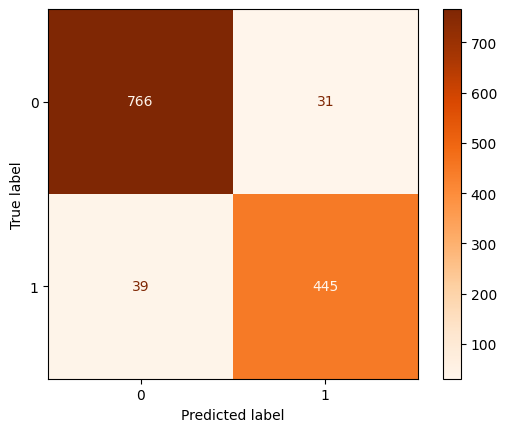

In [33]:
#model training
dt.fit(X_train_final, y_train)

#model predict
dt_train = dt.predict(X_train_final)
dt_test = dt.predict(X_test_final)

#evaluasi menggunakan classification report
print(classification_report(y_train, dt_train))
print(classification_report(y_test, dt_test))

#Confussion matrix display
print('Confusion Matrix Decision Tree pada X_test:', ConfusionMatrixDisplay.from_estimator(dt, X_test_final, y_test, cmap='Oranges'))

Pada Decision Tree model, didapatkan bahwa nilai precision pada kelas 0 train-test yaitu 99%-95% dan dapat dikatakan sebagai model yang goodfit. Model ini dapat memprediksi benar pada kelas Positive yaitu sebanyak 766 orang dan prediksi False Positive 39 orang. Selanjutnya akan dilakukan cross validasi untuk melihat rata-rata nilai model.

In [34]:
#Cross Validation
dt_pipe = Pipeline([
        ('preprocess', full),
        ('model', DecisionTreeClassifier(random_state=0))
    ])

scores_dt = cross_val_score(dt_pipe, X_train, y_train,
                         scoring="precision", cv=5)

print('dt Scores :', scores_dt)
print('dt Scores Mean:', scores_dt.mean())
print('dt Scores Std:', scores_dt.std())

dt Scores : [0.96396396 0.93449782 0.94594595 0.94907407 0.94954128]
dt Scores Mean: 0.948604616996308
dt Scores Std: 0.009413581936760488


Berdasarkan hasil *cross validation*, rata-rata skor Decision Tree Model adalah 0.948 dengan nilai standar deviasi 0.009. nilai maksimum yang dapat dicapai pada model ini adalah 0.964. Model ini menunjukkan bahwa memiliki performa yang baik dengan kecilnya standar deviasi atau nilai erornya.

### **Random Forest Classifier**

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1859
           1       1.00      0.98      0.99      1129

    accuracy                           0.99      2988
   macro avg       0.99      0.99      0.99      2988
weighted avg       0.99      0.99      0.99      2988

              precision    recall  f1-score   support

           0       0.95      0.96      0.96       797
           1       0.93      0.92      0.93       484

    accuracy                           0.95      1281
   macro avg       0.94      0.94      0.94      1281
weighted avg       0.95      0.95      0.95      1281

Confusion Matrix Random Forest pada X_test: <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay object at 0x0000018A09E92310>


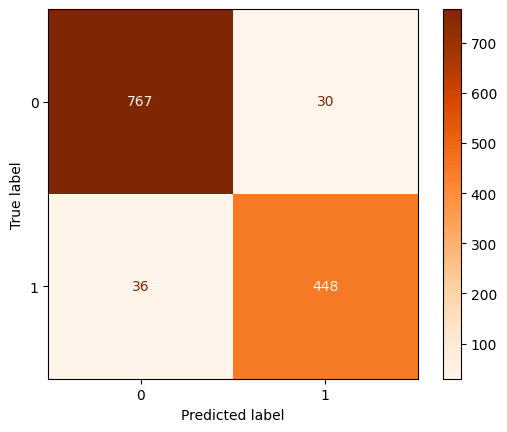

In [35]:
#model training
rf.fit(X_train_final, y_train)

#model predict
rf_train = rf.predict(X_train_final)
rf_test = rf.predict(X_test_final)

#evaluasi menggunakan classification report
print(classification_report(y_train, dt_train))
print(classification_report(y_test, dt_test))

#Confussion matrix display
print('Confusion Matrix Random Forest pada X_test:', ConfusionMatrixDisplay.from_estimator(rf, X_test_final, y_test, cmap='Oranges'))

Pada Random Forest model, didapatkan bahwa nilai precision pada kelas 0 train-test yaitu 99%-95% dan dapat dikatakan sebagai model yang goodfit. Model ini dapat memprediksi benar pada kelas Positive yaitu sebanyak 767 orang dan prediksi False Positive 36 orang. Selanjutnya akan dilakukan cross validasi untuk melihat rata-rata nilai model.

In [36]:
#Cross Validation
RF_pipe = Pipeline([
        ('preprocess', full),
        ('model', RandomForestClassifier(random_state=0))
    ])

scores_rf = cross_val_score(RF_pipe, X_train, y_train,
                         scoring="precision", cv=5)

print('RF Scores :', scores_rf)
print('RF Scores Mean:', scores_rf.mean())
print('RF Scores Std:', scores_rf.std())

RF Scores : [0.96396396 0.93449782 0.95909091 0.94977169 0.95890411]
RF Scores Mean: 0.9532456977471035
RF Scores Std: 0.010436638654032097


Berdasarkan hasil *cross validation*, rata-rata skor Random Forest Model adalah 0.953 dengan nilai standar deviasi 0.01. nilai maksimum yang dapat dicapai pada model ini adalah 0.964. Nilai standar deviasi pada model ini sedikit lebih besar dibandingkan dengan Decision Tree Model, namun nilai rata-ratanya sedikit lebih besar.

### **Gradient Boosting Classifier**

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1859
           1       0.97      0.97      0.97      1129

    accuracy                           0.98      2988
   macro avg       0.98      0.98      0.98      2988
weighted avg       0.98      0.98      0.98      2988

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       797
           1       0.95      0.93      0.94       484

    accuracy                           0.95      1281
   macro avg       0.95      0.95      0.95      1281
weighted avg       0.95      0.95      0.95      1281

Confusion Matrix Random Forrest    : <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay object at 0x0000018A0B8C3E80>


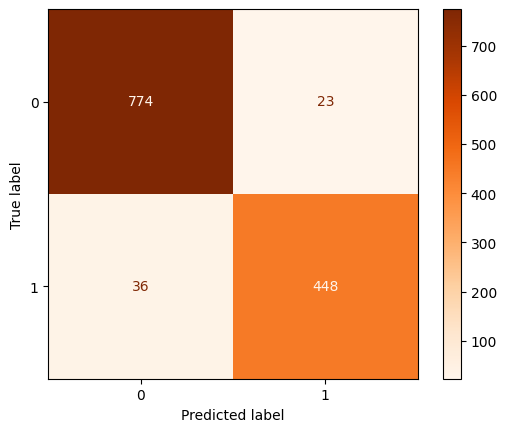

In [37]:
#model train
gb.fit(X_train_final, y_train)

#model predict
gb_train = gb.predict(X_train_final)
gb_test = gb.predict(X_test_final)

#evaluasi menggunakan classification report
print(classification_report(y_train, gb_train))
print(classification_report(y_test, gb_test))

#Confussion matrix display
print('Confusion Matrix Random Forrest    :', ConfusionMatrixDisplay.from_estimator(gb, X_test_final, y_test, cmap='Oranges'))

Pada Gradient Boosting model, didapatkan bahwa nilai precision pada kelas 0 train-test yaitu 98%-96% dan dapat dikatakan sebagai model yang goodfit. Model ini dapat memprediksi benar pada kelas Positive yaitu sebanyak 774 orang dan prediksi False Positive 36 orang. Selanjutnya akan dilakukan cross validasi untuk melihat rata-rata nilai model.

In [38]:
#cross validation
gb_pipe = Pipeline([
        ('preprocess', full),
        ('model', GradientBoostingClassifier(random_state=0))
    ])

scores_gb = cross_val_score(gb_pipe, X_train, y_train,
                         scoring="precision", cv=5)

print('gb Scores :', scores_gb)
print('gb Scores Mean:', scores_gb.mean())
print('gb Scores Std:', scores_gb.std())

gb Scores : [0.95575221 0.93965517 0.96396396 0.95067265 0.96244131]
gb Scores Mean: 0.9544970618122077
gb Scores Std: 0.008822886490899086


Berdasarkan hasil *cross validation*, rata-rata skor Gradient Boosting Model adalah 0.954 dengan nilai standar deviasi 0.008. nilai maksimum yang dapat dicapai pada model ini adalah 0.964. 

Ketiga model menunjukkan performa yang serupa, namun diantara 3 model tersebut terdapat satu model yang memiliki performa paling baik yaitu **Gradient Boosting Classifier** karena :
- memiliki gap antara nilai train-test paling kecil yaitu 0.02 sehingga performanya goodfit dengan nilai error paling kecil
- dapat memprediksi kelas Positive paling Tinggi yaitu 774 orang `Approved`, dan False Positive yang paling kecil yaitu 36 orang yang `Rejected` terprediksi sebagai `Approved`
- memiliki nilai rata-rata dari hasil cross validasi paling tinggi yaitu 0.9544
- memiliki nilai standar deviasi paling kecil yaitu 0.008 yang mengindikasikan nilai eror yang kecil 

Selanjutnya, untuk meningkatkan performa yang lebih baik lagi, akan dilakukan hyperparameter tuning pada Gradient Boost Model

### **Hyperparameter tuning**

In [39]:
#mengatur parameter
params = {
    'n_estimators': [200, 300, 100],
    'learning_rate': [0.01, 0.1, 0.02],
    'max_depth': [3, 2, 5],
    'min_samples_split': [15, 9, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 0.9, 0.7],
    'max_features': ['auto', 'sqrt', 'log2'],
    'random_state':[35,87,99]
}

#### Random Search

Menggunakan Random Search untuk mencari parameter terbaik karena efisiensi waktu.

In [40]:
#define random search
random_search = RandomizedSearchCV(gb, params, cv=5,
                           scoring='precision',
                           return_train_score=True)
random_search.fit(X_train_final, y_train)

RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=0),
                   param_distributions={'learning_rate': [0.01, 0.1, 0.02],
                                        'max_depth': [3, 2, 5],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [15, 9, 10],
                                        'n_estimators': [200, 300, 100],
                                        'random_state': [35, 87, 99],
                                        'subsample': [0.8, 0.9, 0.7]},
                   return_train_score=True, scoring='precision')

In [41]:
#show best parameter
random_search.best_params_

{'subsample': 0.8,
 'random_state': 35,
 'n_estimators': 200,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'log2',
 'max_depth': 2,
 'learning_rate': 0.01}

In [42]:
#show score before tuning
print('Skor sebelum tuning :', scores_gb.mean())

#show after tuning
print('Skor setelah tuning :', random_search.best_score_)

Skor sebelum tuning : 0.9544970618122077
Skor setelah tuning : 0.9852946995292948


Setelah dilakukan hyperparameter tuning dengan random search, nilai akurasi mengalami peningkatan dari 0.95 menjadi 0.98. Selanjutnya akan dilakukan model saving dengan parameter terbaik.

### **Save Model**

In [43]:
#model definition
bestmodel = GradientBoostingClassifier(subsample=0.9, 
                                   random_state=87, 
                                   n_estimators=100, 
                                   min_samples_split=10, 
                                   min_samples_leaf=2, 
                                   max_features='log2', 
                                   max_depth=3, 
                                   learning_rate=0.01)
#model training                             
bestmodel.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.01, max_features='log2',
                           min_samples_leaf=2, min_samples_split=10,
                           random_state=87, subsample=0.9)

In [44]:
#menggabungkan pipeline preprocessing dengan model
model_final = Pipeline([
    ("preprocess", full),
    ("classification", random_search.best_estimator_)
])

#Saving model
joblib.dump(model_final, open('classification.pkl', 'wb'))

## Modelling Clustering

Dilakukan customer segmentation guna menggaet calon debitur berdasarkan cluster , kemampuan bayar sehingga menignkatkan revenue perusahaan karena peningkatan debitur

In [45]:
#copy dataframe untuk clustering
dfc = df.copy()
dfc.head()

,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


Untuk Clustering menggunakan metode K-Means, feature yang dapat dimasukkan hanyalah numerical features sehingga akan dilakukan drop pada categorical features 

### Preprocess

In [46]:
#drop categorical features 
dfc.drop(['no_of_dependents','education','self_employed','loan_term','loan_status'], inplace=True, axis=1)
dfc.head()

,income_annum,loan_amount,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value
0,9600000,29900000,778,2400000,17600000,22700000,8000000
1,4100000,12200000,417,2700000,2200000,8800000,3300000
2,9100000,29700000,506,7100000,4500000,33300000,12800000
3,8200000,30700000,467,18200000,3300000,23300000,7900000
4,9800000,24200000,382,12400000,8200000,29400000,5000000


Selanjutnya dilakukan pengecekan nilai skew untuk menentukan metode handling outlier dan scaling.

In [47]:
# check skewness
for i in dfc.columns:
    print(i, ': ', dfc[i].skew())

income_annum :  -0.012814425096650109
loan_amount :  0.30872388482299223
cibil_score :  -0.009039277330065707
residential_assets_value :  0.9784505965115631
commercial_assets_value :  0.9577908874986114
luxury_assets_value :  0.3222075028955774
bank_asset_value :  0.5607250089736816


Ditemukan bahwa semua feature memiliki nilai <1 yang berarti handling outliers dapat dilakukan dengan metode *capping-iqr* dan scaling menggunakan *Standard Scaler*

In [48]:
#membuat pipeline untuk capping dan scaling
df_pipe = Pipeline([
    ('wins', Winsorizer(capping_method='gaussian', fold=3, tail='both')),
    ('scaler', StandardScaler())
    ])

In [49]:
#train model
processed = df_pipe.fit_transform(dfc)
processed

array([[ 1.61797904,  1.63305171,  1.03279241, ...,  2.88200949,
         0.83202837,  0.93030441],
       [-0.34174956, -0.32441406, -1.06105118, ..., -0.6323746 ,
        -0.69499321, -0.51593638],
       [ 1.4398219 ,  1.61093345, -0.54484044, ..., -0.10749905,
         1.99651964,  2.40731629],
       ...,
       [ 0.51340474,  0.96950399, -0.82904635, ...,  1.69533434,
         0.3266831 ,  0.71490685],
       [-0.34174956, -0.25805929,  1.04439265, ..., -0.97468474,
        -0.11274758,  0.25334064],
       [ 1.47545332,  1.61093345,  0.04097176, ...,  1.55841029,
         2.26017804,  2.16114764]])

Untuk menentukan jumlah cluster yang optimal, akan dilakukan perhitungan dengan metode silhouette score.

In [50]:
#membuat silhouette score function
def plot_silhouette(model,range_n_clusters,X,model_name):
    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        clusterer = model(n_clusters=n_clusters)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')


        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle((f"Silhouette analysis for {model_name} clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

In [51]:
#mengubah data menjadi dataframe
df_processed = pd.DataFrame(processed)

For n_clusters = 2 The average silhouette_score is : 0.38047819874848116
For n_clusters = 3 The average silhouette_score is : 0.27040074352784005


For n_clusters = 4 The average silhouette_score is : 0.25668072850875473
For n_clusters = 5 The average silhouette_score is : 0.24701170975540118


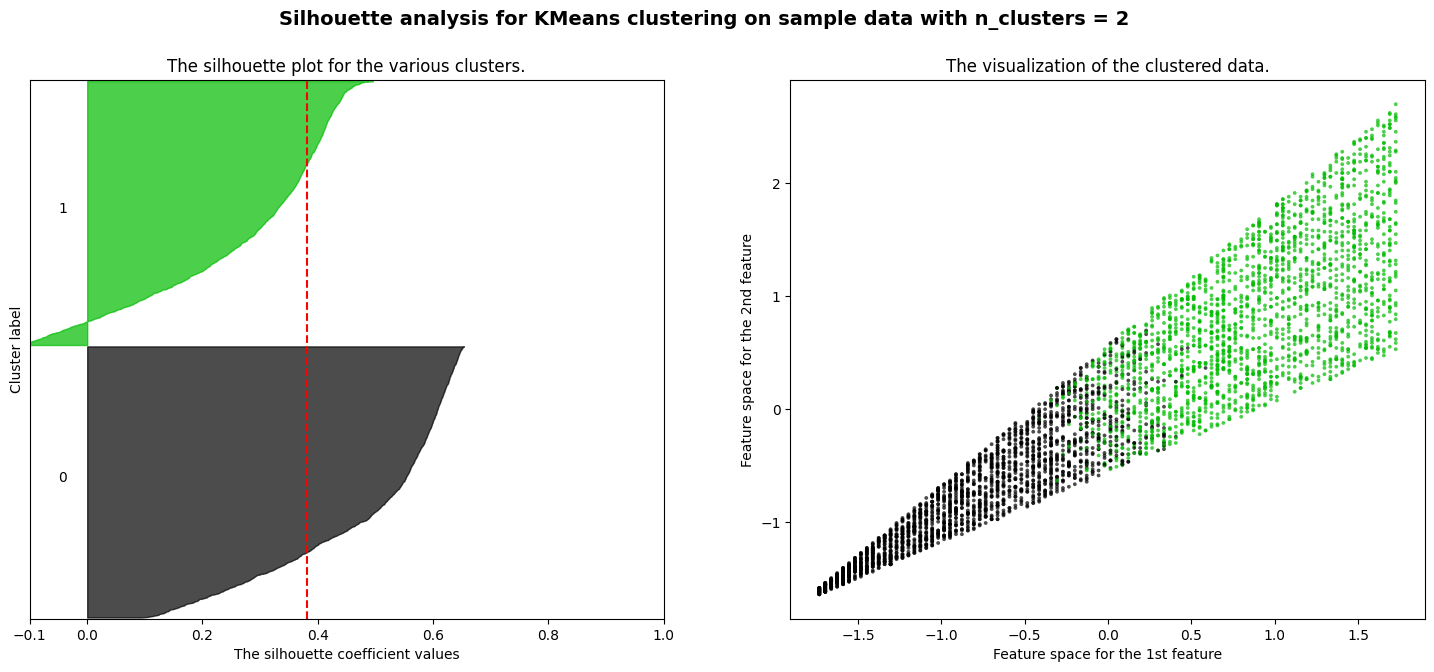

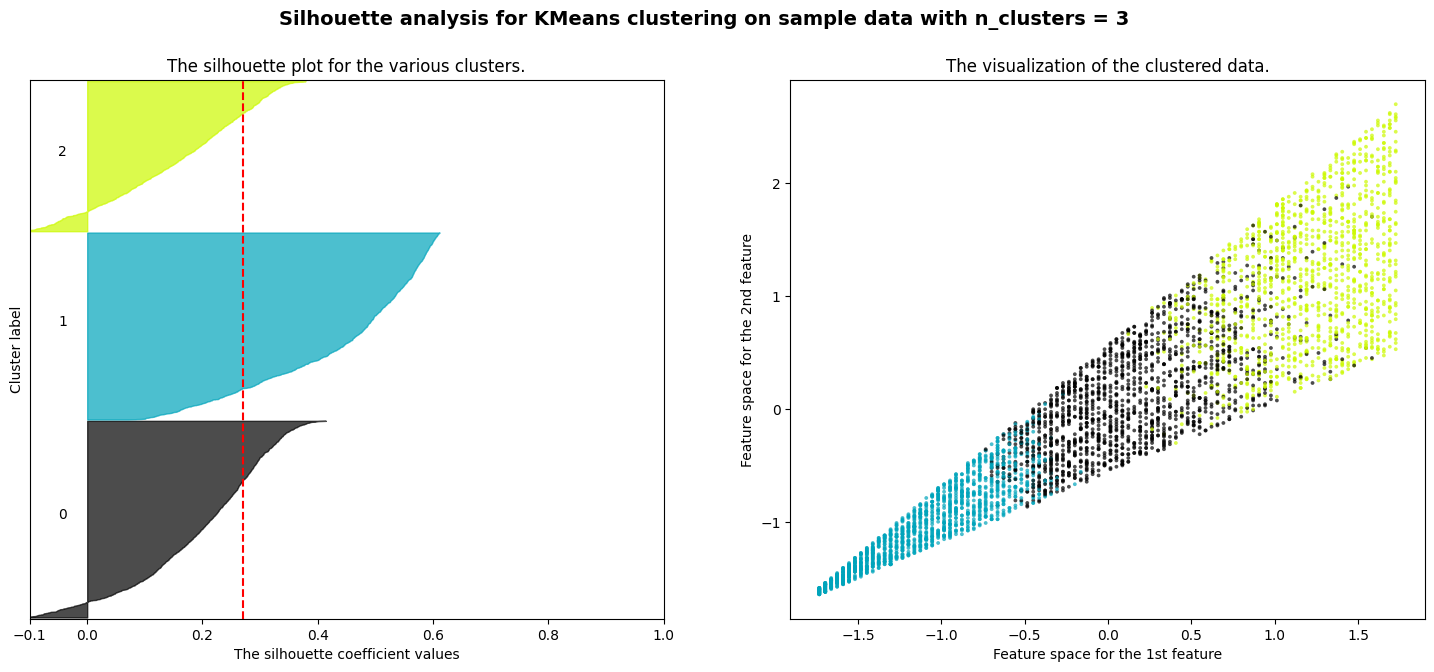

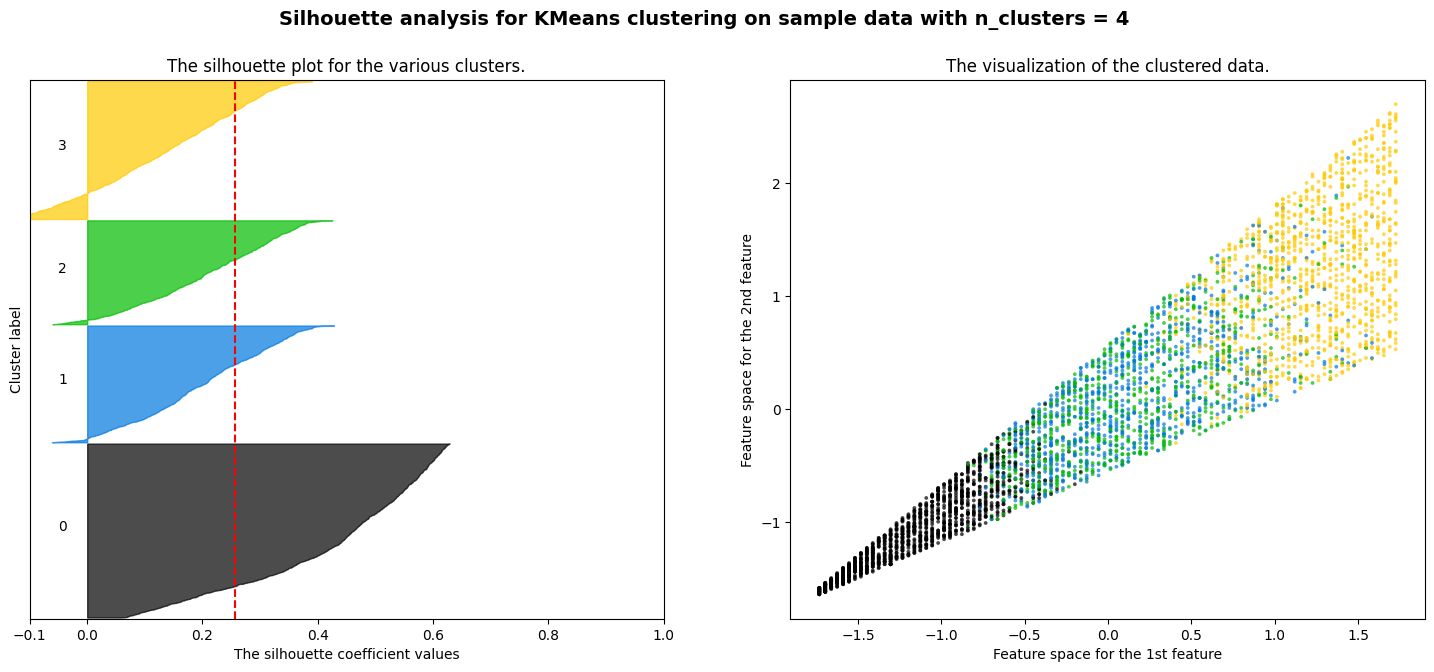

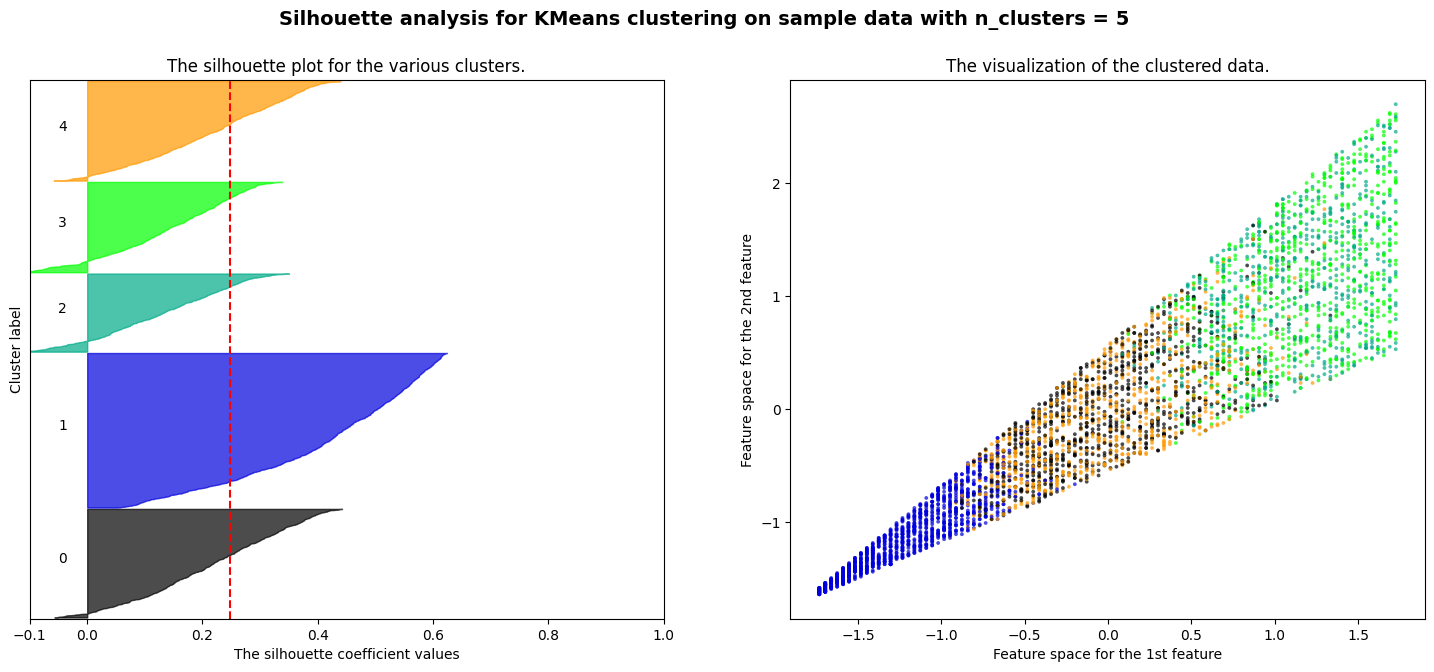

In [52]:
#membuat perbandingan jumlah cluster
K = range(2, 6)

#show silhouette plot
plot_silhouette(KMeans,K,df_processed.values,'KMeans')

Berdasarkan silhouette score, cluster yang optimal adalah 2 cluster dengan nilai 0.38. Kemudian dibuktikan juga dengan grafik silhouette dimana grafik dengan 2 cluster memiliki bentuk yang cenderung stabil (hampir kotak) yang menunjukkan bahwa cluster tersebut bagus

#### Modelling

In [53]:
#membuat 2 cluster dengan K-Means 
km = KMeans(n_clusters=2, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)

In [54]:
#train dan predict model
clusters = km.fit_predict(processed)

In [55]:
#membuat data frame baru pada hasil cluster
clusteringfull = df_processed.copy()

#menambah kolom hasil cluster
clusteringfull['clusters'] = clusters

In [56]:
#reset index
dfc = dfc.reset_index(drop=True)
clusteringfull = clusteringfull.reset_index(drop=True)

In [57]:
#membuat dataframe final untuk analisis cluster
df_final = pd.concat([df, clusteringfull['clusters']], axis=1)
df_final.head()

,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status,clusters
0,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved,0
1,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected,1
2,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected,0
3,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected,0
4,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected,0


### Save Model

In [58]:
#membuat pipeline gabungan preprocessing dan model
clustering = Pipeline([
    ('preprocessing', df_pipe),
    ('model', KMeans(n_clusters=2, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0))
])

#train dan predict 
clustering.fit(dfc)
c_res = clustering.predict(dfc)

In [59]:
#Saving model
joblib.dump(clustering, open('clustering.pkl', 'wb'))

### Exploratory Data Analysis for Cluster

utamakan gunakan plot yang spesifik melihat distribusi seperti violinplot,scatterplot,kde,boxplot untuk eda setelah cluster terbentuk
untuk plot shilhouette jangan lupa perhatikan proporsi cluster dan besaran data miss klasifikasi

In [60]:
# for example purpose, using .describe
df_final.groupby('clusters').mean()

,no_of_dependents,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value
clusters,,,,,,,,,
0,2.531814,7.475166e+06,2.247493e+07,10.905983,595.94207,1.127631e+07,7.628727e+06,2.254843e+07,7.448243e+06
1,2.466482,2.706750e+06,7.985437e+06,10.895053,603.82478,3.769163e+06,2.387564e+06,7.899769e+06,2.570273e+06


Berdasarkan tabel di atas, dapat diketahui bahwa :   

**Cluster 0:**
- Rata-rata pendapatan tahunan (income_annum) adalah sekitar 7,475,166.
- Rata-rata jumlah pinjaman (loan_amount) adalah sekitar 22,474,930.
- Rata-rata skor kredit (cibil_score) adalah sekitar 595.94, menunjukkan profil kredit yang baik.
- Rata-rata nilai aset residensial (residential_assets_value) adalah sekitar 11,276,310 
- Rata-rata nilai aset komersial (commercial_assets_value) adalah sekitar 7,628,727.
- Rata-rata nilai aset mewah (luxury_assets_value) adalah sekitar 22,548,430
- Rata-rata nilai aset bank (bank_asset_value) adalah sekitar 7,448,243.

**Cluster 1:**
- Rata-rata pendapatan tahunan (income_annum) adalah sekitar 2,706,750.
- Rata-rata jumlah pinjaman (loan_amount) adalah sekitar 7,985,437.
- Rata-rata skor kredit (cibil_score) adalah sekitar 603.82, juga menunjukkan profil kredit yang baik.
- Rata-rata nilai aset residensial (residential_assets_value) adalah sekitar 3,769,163
- Rata-rata nilai aset komersial (commercial_assets_value) adalah sekitar 2,387,564.
- Rata-rata nilai aset mewah (luxury_assets_value) adalah sekitar 7,899,769
- Rata-rata nilai aset bank (bank_asset_value) adalah sekitar 2,570,273.

Sehingga dapat disimpulkan bahwa cluster 0 merupakan calon debitur yang berasal dari tingkat ekonomi kelas menengah ke atas, dan cluster 1 berasal dari tingkat ekonomi menengah kebawah apabila dibandingkan dari pendapatan tahunan serta aset yang dimiliki. Dari masing-masing kelas, dapat ditentukan strategi rekomendasi terkait program peminjaman uang agar calon debitur tetap bisa meminjam uang dengan jumlah pinjaman serta tenor yang sesuai sehingga tidak akan menimbulkan kerugian pada perusahaan. 

**Strategi Marketing**:
1. Cluster 0
    - Cluster 0 memiliki profil keuangan yang lebih kuat dengan pendapatan dan nilai aset yang tinggi. Perlu mempertimbangkan penawaran pinjaman dengan jumlah yang lebih besar dan jangka waktu yang lebih singkat untuk memenuhi kebutuhan proyek bisnis atau investasi yang lebih besar.
    - Menambahkan jasa pengelola keuangan sebagai tambahan bidang bisnis baru

2. Cluster 1
    - Meskipun memiliki pendapatan dan aset yang lebih rendah, mereka cenderung mengajukan pinjaman dengan jumlah yang lebih kecil (rata-rata hampir 8 juta) dan jangka waktu yang hampir sama dengan cluster 0.
    - Strategi yang tepat untuk kelompok ini adalah pinjaman kecil dengan waktu tenor fleksibel, kemudian membuat program apabila pembayarannya lancar dan lunas, maka jumlah uang yang bisa dipinjam akan meningkat.

Sehingga Cluster 0 akan diberi label sebagai Kelas A, cluster 1 diberi label sebagai Kelas B 

# **Conclusion**

1. **Loan Approval Prediction:**
   - Dalam proyek ini, metrik yang digunakan untuk evaluasi model adalah `precision`. Ini karena fokus utama adalah meminimalkan kesalahan dalam memprediksi pelanggan yang seharusnya ditolak (False Positive) karena dapat berdampak buruk pada perusahaan.
   - Terdapat ketidakseimbangan distribusi `loan_status` dengan proporsi 60:40 antara calon debitur yang disetujui dan ditolak. Hal ini menunjukkan bahwa masih ada pelanggan yang mengajukan pinjaman tanpa evaluasi yang memadai.
   - Variabel yang berpengaruh signifikan terhadap `loan_status` adalah skor kredit (CIBIL score) dan jangka waktu pinjaman (loan term), yang sejalan dengan analisis EDA.
   - Model Gradient Boosting awal memiliki akurasi 95%, namun setelah tuning berhasil meningkatkan akurasi menjadi 98%, menunjukkan kemampuan model dalam melakukan prediksi yang lebih akurat.

2. **Segmentasi Pelanggan:**
   - Dua kelompok pelanggan (cluster) diidentifikasi, yang disebut Kelas A (Cluster 0) dan Kelas B (Cluster 1).
   - Kelas A memiliki profil keuangan yang lebih kuat dengan pendapatan dan nilai aset yang tinggi, sementara Kelas B memiliki pendapatan dan aset yang lebih rendah.
   - Strategi pemasaran yang direkomendasikan untuk Kelas A adalah penawaran pinjaman dengan jumlah yang lebih besar dan jangka waktu yang lebih singkat. Untuk Kelas B, direkomendasikan strategi pinjaman kecil dengan tenor fleksibel.
   - Penggunaan strategi pemasaran yang disesuaikan untuk masing-masing kelas dapat membantu meningkatkan pendapatan perusahaan secara efektif.

Kesimpulannya, proyek ini berhasil mengembangkan model prediksi persetujuan pinjaman yang akurat dan efektif, serta melakukan segmentasi pelanggan untuk merancang strategi pemasaran yang tepat sasaran. Dengan kombinasi ini, diharapkan perusahaan dapat mengoptimalkan keputusan persetujuan pinjaman dan meningkatkan pendapatan melalui pendekatan yang disesuaikan untuk setiap kelompok pelanggan.